In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from pycaret.classification import *

In [2]:
seed = 42
np.random.seed(seed)
set_config('seed', seed)

# 1. 데이터 로드

In [3]:
train=pd.read_csv('input/train.csv', index_col=0)#, na_values='?') #인덱스 col=0도 check!
test=pd.read_csv('input/test.csv', index_col=0)#, na_values='?')
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [4]:
train['income']=pd.factorize(train['income'], sort=True)[0]

# 2. EDA & 전처리

## Missing Value

### education

In [5]:
train.drop(['education'],axis=1, inplace=True)
test.drop(['education'],axis=1, inplace=True)

### capital_gain 99999

In [6]:
df = pd.concat([train, test])
df['capital_gain_imsi'] = df['capital_gain'].replace(99999,0)
capital_gain_imsi = pd.DataFrame(df.groupby(['education_num'])['capital_gain_imsi'].mean()).reset_index()
train = train.merge(capital_gain_imsi, on=['education_num'], how='left')
test = test.merge(capital_gain_imsi, on=['education_num'], how='left')
train.loc[train.capital_gain == 99999, 'capital_gain'] = train['capital_gain_imsi']
test.loc[test.capital_gain == 99999, 'capital_gain'] = test['capital_gain_imsi']
train.drop(['capital_gain_imsi'],axis=1, inplace=True)
test.drop(['capital_gain_imsi'],axis=1, inplace=True)

In [7]:
train['imsi'] = train.capital_gain*train.hours_per_week#*train.capital_loss
test['imsi'] = test.capital_gain*test.hours_per_week#*train.capital_loss

In [8]:
train.loc[train['capital_loss'] > 3000, 'capital_loss'] = 87.303829734959
test.loc[test['capital_loss'] > 3000, 'capital_loss'] = 87.303829734959

# 3. 모델 학습

In [ ]:
import gc
gc.collect()

In [ ]:
train.columns

In [9]:
%%time
clf = setup(session_id=seed, 
            data = train, target = 'income'
          #, categorical_features=col_cat
          , numeric_features = ['education_num']
          , ignore_features =['fnlwgt']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(26049, 15)"
4,Missing Values,False
5,Numeric Features,7
6,Categorical Features,7
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 16.6 s


In [10]:
best_3 = compare_models(sort = 'F1', n_select = 3
                       ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'xgboost']
                       )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,CatBoost Classifier,0.8674,0.9242,0.6384,0.7747,0.6996,0.6155,0.6205,10.7334
1,Extreme Gradient Boosting,0.8648,0.9225,0.6487,0.7584,0.6991,0.6126,0.6159,2.1005
2,Light Gradient Boosting Machine,0.8641,0.9224,0.6488,0.7559,0.6980,0.6110,0.6142,0.2651
3,Gradient Boosting Classifier,0.8616,0.9182,0.6034,0.7749,0.6783,0.5919,0.5995,1.7491
4,Ada Boost Classifier,0.8559,0.9114,0.6138,0.7463,0.6733,0.5820,0.5868,0.6718
5,Linear Discriminant Analysis,0.8454,0.8999,0.5888,0.7216,0.6480,0.5504,0.5553,0.1684
6,Random Forest Classifier,0.8365,0.8707,0.5785,0.6963,0.6312,0.5274,0.5316,0.1223
7,Extra Trees Classifier,0.8297,0.8541,0.6012,0.6644,0.6309,0.5206,0.5219,0.5301


In [11]:
blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8645,0.9217,0.6375,0.7636,0.6949,0.6087,0.6128
1,0.8613,0.9173,0.6618,0.7383,0.6980,0.6083,0.6098
2,0.8582,0.9226,0.6197,0.7510,0.6791,0.5891,0.5936
3,0.8723,0.9308,0.6418,0.7904,0.7084,0.6277,0.6333
4,0.8719,0.9256,0.6634,0.7750,0.7149,0.6329,0.6361
Mean,0.8656,0.9236,0.6449,0.7637,0.6990,0.6134,0.6171
SD,0.0056,0.0045,0.0163,0.0182,0.0123,0.0156,0.0158


In [12]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8781,0.9295,0.6609,0.8005,0.724,0.6467,0.6516


In [15]:
%%time
final_model = finalize_model(blended)

Wall time: 3min 14s


In [16]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [17]:
submission['prediction'] = predictions['Label']

# 5. 제출

In [18]:
submission.to_csv('output/20201031-2.csv')

In [19]:
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8622,0.9226,0.6246,0.7628,0.6868,0.5996,0.6045
1,0.8598,0.9124,0.6505,0.7390,0.6919,0.6017,0.6037
2,0.8606,0.9248,0.6796,0.7266,0.7023,0.6115,0.6121
3,0.8574,0.9141,0.6331,0.7386,0.6818,0.5906,0.5935
4,0.8566,0.9098,0.6246,0.7423,0.6784,0.5870,0.5906
5,0.8644,0.9319,0.6311,0.7677,0.6927,0.6068,0.6116
6,0.8754,0.9338,0.6602,0.7907,0.7196,0.6403,0.6446
7,0.8652,0.9221,0.6472,0.7605,0.6993,0.6132,0.6165
8,0.8730,0.9255,0.6634,0.7795,0.7168,0.6356,0.6391
9,0.8738,0.9275,0.6731,0.7761,0.7210,0.6400,0.6427


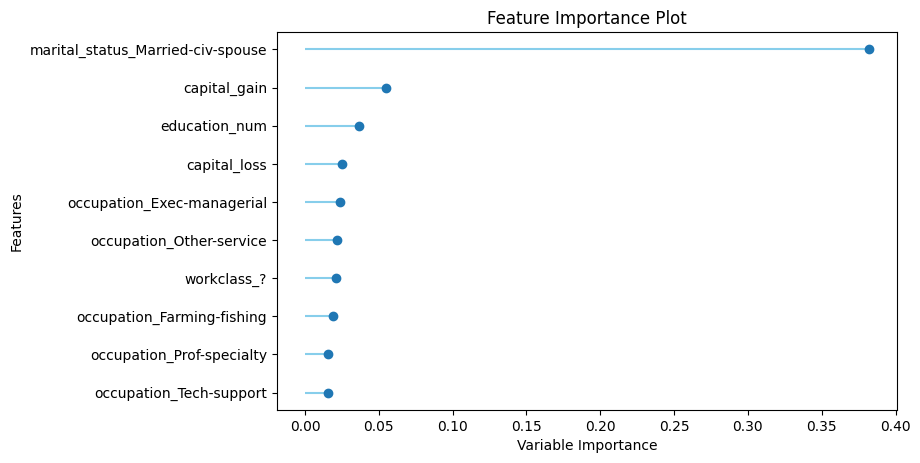

In [20]:
plot_model(estimator = xgboost, plot = 'feature')

In [21]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8559,0.9219,0.6149,0.7451,0.6738,0.5824,0.5868
1,0.8559,0.9147,0.6634,0.7193,0.6902,0.5966,0.5974
2,0.8645,0.9190,0.6764,0.7411,0.7073,0.6194,0.6205
3,0.8582,0.9141,0.6396,0.7378,0.6852,0.5943,0.5968
4,0.8558,0.9114,0.6246,0.7395,0.6772,0.5852,0.5887
5,0.8652,0.9343,0.6375,0.7665,0.6961,0.6104,0.6147
6,0.8738,0.9349,0.6634,0.7824,0.7180,0.6375,0.6411
7,0.8629,0.9210,0.6472,0.7519,0.6957,0.6078,0.6106
8,0.8691,0.9271,0.6440,0.7773,0.7044,0.6213,0.6259
9,0.8801,0.9255,0.6764,0.7977,0.7320,0.6555,0.6592


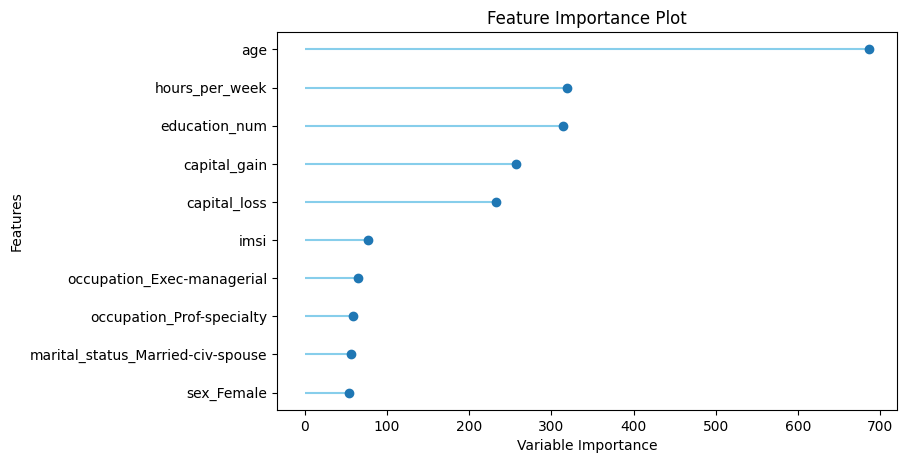

In [22]:
plot_model(estimator = lightgbm, plot = 'feature')